# Школа машинного обучения

### Физтех-Школа Прикладной математики и информатики МФТИ 
### Лаборатория нейронных сетей и глубокого обучения (DeepHackLab)  
дедлайн: 4 апреля 23: 59 (MSK)


## Домашнее задание 2
### Метод k-ближайших соседей 
---


In [55]:
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt
import collections
import numpy as np

import scipy.stats as sps
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from matplotlib.colors import ListedColormap
import matplotlib.collections 

from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

**Вопрос:** Почему важно, чтобы в тестовой и обучающей выборке пропорции классов были максимально похожи? В качестве примера рассмотрите Ирисы Фишера: в нём три класса, каждый занимает по трети датасета. Далее мы разделяем выборку в пропорциях 2:1, например, при кросс-валидации с тремя фолдами. Что может пойти не так?

В этом ноутбуке за равенство классов отвечает StratifiedKFold (см. пример ниже, подробнее: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)

При недостаточном количестве данных можно получить смещение. Класс с меньшей выборкой оказывает меньшее влияние на классификатор. Например: вы решили вылечить рак и у вас будет датасет в котором большинство людей не болеют раком, 
соответственно люди с раком (2% от всего населния мира) будет иметь очень маленькое влияние на модель.

**Задание 1** Примените kNN к классическому <a href="https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0">набору данных "Ирисы Фишера" </a>. Подберите оптимальное число k c помощью поиска по сетке и кросс-валидации. Постройте график зависимости качества от k. Используйте метрику accuracy.

In [56]:
iris = load_iris()

x = iris.data
y = iris.target

# Поиск по сетке

Normal  {'n_neighbors': 6} 0.98
Changed  {'n_neighbors': 1} 0.8066666666666666
Converted  {'n_neighbors': 7} 0.98


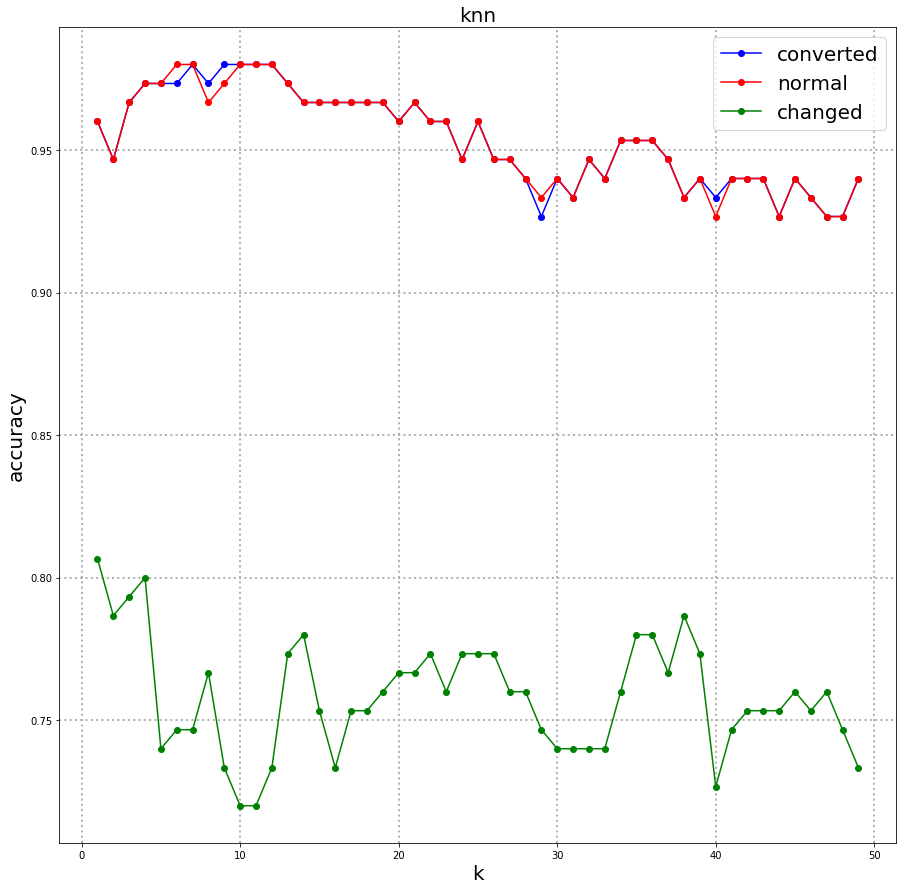

In [57]:
# Вы уже умеете пользоваться GridSearchCV (см семинар по knn)

normal_model = KNeighborsClassifier()
interesting_model = KNeighborsClassifier()
converted_model = KNeighborsClassifier()

params = {'n_neighbors': np.arange(1, 50) }

X_new = x * np.array((100, 1, 1, 1))
interesting_gscv = GridSearchCV(interesting_model, params, cv=5)
interesting_gscv.fit(X_new, y)
print('Changed ', interesting_gscv.best_params_, interesting_gscv.best_score_)

gscv = GridSearchCV(normal_model, params, cv=5)
gscv.fit(x, y)
print('Normal ', gscv.best_params_, gscv.best_score_)

X_converted = x * np.array((100, 100, 100, 100))
converted_gscv = GridSearchCV(converted_model, params, cv=5)
converted_gscv.fit(X_converted, y)
print('Converted ', converted_gscv.best_params_, converted_gscv.best_score_)

plt.figure(figsize=(15, 15))
plt.grid(linestyle=':', linewidth=2)
plt.plot(params['n_neighbors'], converted_gscv.cv_results_['mean_test_score'], 'bo-', label='converted')
plt.plot(params['n_neighbors'], gscv.cv_results_['mean_test_score'], 'ro-', label='normal')
plt.plot(params['n_neighbors'], interesting_gscv.cv_results_['mean_test_score'], 'go-', label='changed')
plt.xlabel('k', fontsize=20)
plt.ylabel('accuracy', fontsize=20)
plt.title('knn',  fontsize=20)
plt.legend(fontsize=20)

Если вы смотрели в данные, то вы видели, что признаки примерно одного порядка, т.к. это длины и ширины в сантиметрах. Предположим теперь, что один из признаков измерялся в десятых долях миллиметра. Точно так же подберите оптимальное k для новых данных, сравните качество и постройте график. Что нужно делать, чтобы такая проблема не возникала?

# Ответ

Нужно приводить все величины в одну систему измерения (на графике видно, что если все величины в измеряются в одной единицей, то отклонений в измерениях почти нет). Ещё было бы неплохо иметь какие-то дополнительные измерения в других единицах

**Задание 2:** Реализуйте kNN. Cравните скорости работы реализации с distance_slow,  distance_fast c реализацией из sklearn. Проверьте, что качество такое же. 
Считать, что интерфейс fit и predict такой же, как у KNeighborsClassifier из sklearn

In [58]:
def distance_slow(v, a_list):
    """
    Функция, по вектору v и спиcку векторов a
    находящая попарные расстояния v <-> a[i]
    и возвращающая их как numpy.ndarray той же длины,
    что и список a
    (Работает медленно)
    """
    result = []
    for i in range(a_list.shape[0]):
        length = 0
        for j in range(a_list.shape[1]):
            length += (v[j] - a_list[i, j]) ** 2
        result.append(length)
    return np.array(result)

In [59]:
def distance_fast(v, a_list):
    """
    Аналог distance_slow. Использует numpy, работает быстро.
    """
    # return < .. Достаточно одной строчки. Считатайте, что v, a_list - numpy.ndarray подходящего размера ..
    # return ((a_list - v) ** 2).sum()
    # return list(map(lambda x: np.linalg.norm(v - x) ** 2, a_list))
    return np.sum((v - a_list) ** 2, axis = 1)
    
# v = np.ndarray(shape = 1, buffer = np.array([1 , 2]))
# a_list = np.ndarray(shape = 2, buffer = np.array([[1, 2], [3, 4]]))

a_list = np.array([[1, 2], [3, 4]])
v = np.array([1, 2])

print(distance_fast(v, a_list))
print(distance_slow(v, a_list))

[0 8]
[0 8]


In [60]:
class kNNClassifier:
    def __init__(self, k=3, distance = distance_slow):
        """
        Parameters
        ----------
        k: int
            Число соседей

        distance: *alias
            функция, по вектору v и спиcку векторов a
            находящая попарные расстояния v <-> a[i]
            и возвращающая их как numpy.ndarray той же длины,
            что и список a
        """
        self._k = k
        self._distance = distance
    
    def fit(self, X_train, y_train):
        self._X = np.copy(X_train)  # Копируем данных, чтобы они не перезаписывались извне
        self._y = np.copy(y_train)
        return self
        
    def predict(self, X_test):
        X_test = np.array(X_test)
        predictions = []
        # print(X_test)
        # objects_count = < .. число объектов, которые нужно классифицировать .. >
        
        objects_count = X_test.shape[0]
        
        # print(X_test.shape[0])
        # print(X_test.shape[1])
        # print(X_test[0])
        # print(len(X_test))
        for i in range(objects_count):
            pairwise_distances = self._distance(X_test[i], self._X) # < .. вызовите self._distance .. >
            
            k_nearest = self._y[np.argsort(pairwise_distances)[:self._k]]  # нашли k ближайших.
            
            
            '''
            unique_values, counts = < .. используйте numpy.unique с return_counts=True, 
                                        чтобы найти какие классы есть среди k соседей 
                                        и сколько раз каждый из них встречается .. >
            '''
            unique_values, counts = np.unique(k_nearest, return_counts=True)      
            # print('----->', unique_values, counts, k_nearest)
            # Если вы что-то не понимаете - у numpy замечательная документация       
                
            prediction = unique_values[np.argmax(counts)]
            # Предсказываем класс, представителей которого больше всего
            
            predictions.append(prediction) 
            
        return predictions
    
    def get_params(self, deep=False):
        """
        Функция, необходимая для работы GridSearchCV
        Возвращает параметры данного экземпляра класса
        """
        return {
            "k": self._k,
            "distance": self._distance
        }
    
    def set_params(self, **params):
        """
        Функция, необходимая для работы GridSearchCV
        Устанавливает параметры из params 
        (В данном случае пересоздаёт экземпляр класса 
        и возвращает его)
        """
        self.__init__(**params)
        return self

In [61]:
data = load_iris()


x = data.data
y = data.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state = 42)

In [62]:

clf = KNeighborsClassifier(n_neighbors=3)
print(sklearn.model_selection.cross_val_score(clf, x, y, cv=StratifiedKFold(shuffle = False), scoring="accuracy", ))

clf = kNNClassifier(k = 3)
print(sklearn.model_selection.cross_val_score(clf, x, y, cv=StratifiedKFold(shuffle = False), scoring="accuracy", ))


[0.98039216 0.96078431 1.        ]
[0.98039216 0.96078431 1.        ]


In [63]:
%%time
clf = kNNClassifier()

params = {
    "k":[1, 3, 5, 7, 9, 11, 13, 15, 17],
    "distance":[distance_slow]
}
gscv = GridSearchCV(clf, params, cv=StratifiedKFold(shuffle = False, n_splits=5), scoring="accuracy", )
gscv.fit(x, y)
print("Best params: {}. Best score: {}".format(gscv.best_params_, gscv.best_score_))

Best params: {'k': 7, 'distance': <function distance_slow at 0x7f4ed3d92840>}. Best score: 0.98
CPU times: user 3.19 s, sys: 0 ns, total: 3.19 s
Wall time: 3.19 s


In [64]:
%%time
clf = kNNClassifier()

params = {
    "k":[1, 3, 5, 7, 9, 11, 13, 15, 17],
    "distance":[distance_fast]
}
gscv = GridSearchCV(clf, params, cv=StratifiedKFold(shuffle = False, n_splits=5), scoring="accuracy", )
gscv.fit(x, y)
print("Best params: {}. Best score: {}".format(gscv.best_params_, gscv.best_score_))

Best params: {'k': 7, 'distance': <function distance_fast at 0x7f4ed3d92510>}. Best score: 0.98
CPU times: user 482 ms, sys: 0 ns, total: 482 ms
Wall time: 479 ms


In [65]:
%%time
clf = KNeighborsClassifier(n_neighbors=3)

params = {
    "n_neighbors":[1, 3, 5, 7, 9, 11, 13, 15, 17],
}
gscv = GridSearchCV(clf, params, cv=StratifiedKFold(shuffle = False, n_splits=5), scoring="accuracy", )
gscv.fit(x, y)
print("Best params: {}. Best score: {}".format(gscv.best_params_, gscv.best_score_))

Best params: {'n_neighbors': 7}. Best score: 0.98
CPU times: user 127 ms, sys: 0 ns, total: 127 ms
Wall time: 125 ms


# Brute

In [66]:
%%time
clf = KNeighborsClassifier(n_neighbors=3, algorithm='brute')

params = {
    "n_neighbors":[1, 3, 5, 7, 9, 11, 13, 15, 17],
}
gscv = GridSearchCV(clf, params, cv=StratifiedKFold(shuffle = False, n_splits=5), scoring="accuracy", )
gscv.fit(x, y)
print("Best params: {}. Best score: {}".format(gscv.best_params_, gscv.best_score_))

Best params: {'n_neighbors': 7}. Best score: 0.98
CPU times: user 350 ms, sys: 625 ms, total: 976 ms
Wall time: 221 ms


# KDTree

In [67]:
%%time
clf = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree')

params = {
    "n_neighbors":[1, 3, 5, 7, 9, 11, 13, 15, 17],
}
gscv = GridSearchCV(clf, params, cv=StratifiedKFold(shuffle = False, n_splits=5), scoring="accuracy", )
gscv.fit(x, y)
print("Best params: {}. Best score: {}".format(gscv.best_params_, gscv.best_score_))

Best params: {'n_neighbors': 7}. Best score: 0.98
CPU times: user 215 ms, sys: 312 ms, total: 527 ms
Wall time: 129 ms


# Вывод по задаче:

Медленнее всего работает самописный knn с **distance_slow** ~=3.33 sec на ``GridSearchCV``.
Сапописный knn с **distance_fast** тратит в ~= 6.85 раз меньше времени (490 ms).

knn из ``sklearn`` работает быстрее самописного knn

Скорость работы ``sklearn.KNeighborsClassifier``

<table> 
    <tr>
        <td>
            <h2> Auto </h2>
        </td>
        <td>
            <h2> Brute </h2>
        </td>
        <td>
            <h2> KDTree </h2>
        </td>
    </tr>
    
    <tr>
        <td>
            <h2>  112 ms </h2>
        </td>
        <td>
            <h2>  150 ms </h2>
        </td>
        <td>
            <h2> 140 ms </h2>
        </td>
     </tr>
</table>


__Из таблицы видно, что самый тривиальный способ - самый медленный. Но чтобы получить более точные результаты по алгоритмам, нужно иметь выборку больше, чем в данной задаче.__

**Комментарий:** Интересующиеся могут изучить <a href="https://habrahabr.ru/post/312882/">kd-tree</a>, позволяющее рассматривать меньшее число расстояний. Так же эта структура используется для отрисовки компьютерной графики.

**Задача 3:** Пусть в данных предыдущей задачи мы получили измерения только двух признаков. Тогда признаки одного обьекта можно представить как точку на плоскости, которой в соответствие поставлен некоторый класс (можно визуализировать это как цвет). Постройте графики, изображающие принадлежность всех точек плоскости к классам для различных k.

In [68]:
data = load_iris()
X = data.data[:, [False, True, True, False]]
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

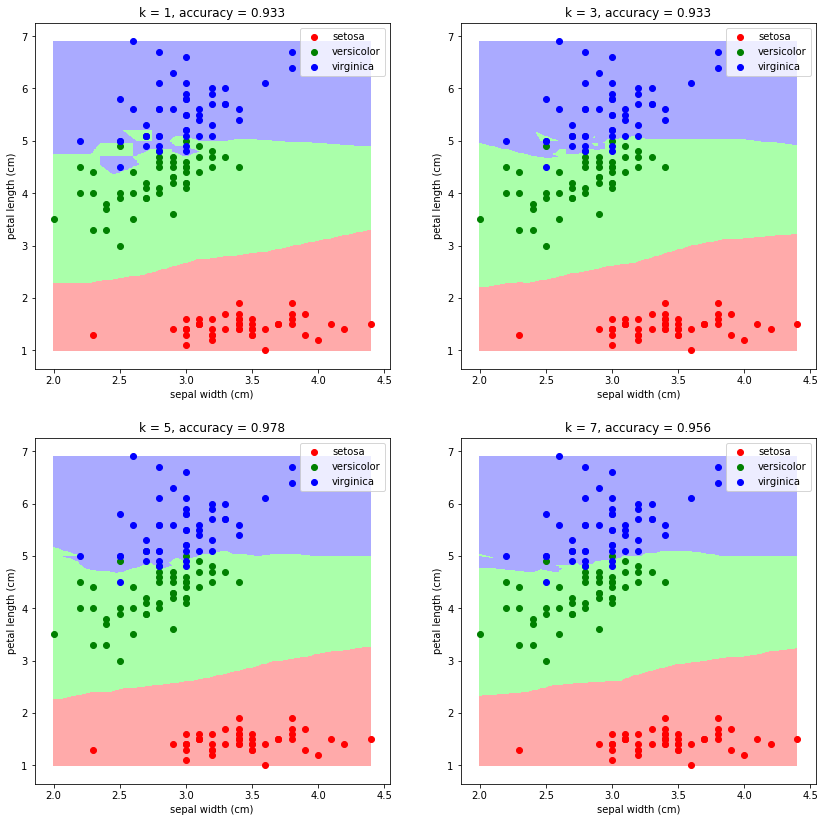

In [69]:
cmap = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
plt.figure(figsize=(14, 14))
for i, k in enumerate([1, 3, 5, 7]):
    plt.subplot(221 + i)

    h = 400
    xx, yy = np.meshgrid(
        np.linspace(X[:, 0].min(), X[:, 0].max(), h),
        np.linspace(X[:, 1].min(), X[:, 1].max(), h)
    )
    
    X_grid = np.c_[xx.ravel(), yy.ravel()]
        
    # Обучите (k)NN на данных X_train, y_train
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    Z  = knn.predict(X_grid)
    z = knn.predict(X_test)
    # Z = < .. предсказание на X_grid ..>
    
    acc = accuracy_score(y_test, z)
    
   
   
   
    # acc = < .. вычислите качество на y_test, X_test. Используйте функцию accuracy_score .. >
    # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    
    
    
    plt.title("k = {}, accuracy = {}".format(k, round(acc, 3)))
    zz = np.array(Z).reshape(xx.shape)
   
    # Вызовите plt.pcolormesh для точек xx, yy, zz и цветовой схемы cmap
    # https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.pcolormesh.html
    
    plt.pcolormesh(xx, yy, zz, cmap=cmap)
    
    plt.xlabel(data["feature_names"][1])
    plt.ylabel(data["feature_names"][2])
    for i in range(3):
        plt.scatter(X[y == i, 0], X[y == i, 1], color=["red", "green", "blue"][i], label=data["target_names"][i])
    plt.legend()

plt.show()

Как меняется форма разделяющей кривой при увеличении k и как это сказывается на тестовом качестве? Не забывайте, что иногда в данных встречаются недостоверные измерения, вызванные множеством факторов, например, проблемами при переводе данных из одного формата в другой, в том числе при занесении непосредственных измерений в компьютер.

# Ответ

При увеличении k разделяющая кривая начинает выравниваться по x и это плохо влияет на тестовое качество модели, из-за того, что кривая выровнилась, то точки, которые лежали рядом, могут попасть из области одного цвета в другую

**Задание 4*:** Предлагается датасет, состоящий из писем на две тематики. Задача - научиться классифицировать письма по темам.

In [70]:
categories = [
    'rec.autos',  # тем больше, чем две. Попробуйте другие.)
    'sci.space',
]

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

X = dataset.data
y = dataset.target

In [71]:
len(X), len(y), y

(1977, 1977, array([1, 0, 0, ..., 0, 1, 0]))

Рассмотрим два письма из выборки

In [72]:
print(X[-2])  # Класс 1

From: prb@access.digex.net (Pat)
Subject: Re: HST Servicing Mission Scheduled for 11 Days
Organization: Express Access Online Communications USA
Lines: 14
NNTP-Posting-Host: access.digex.net

In article <C6A2At.E9z@zoo.toronto.edu> henry@zoo.toronto.edu (Henry Spencer) writes:
>
>No, the thing is designed to be retrievable, in a pinch.  Indeed, this
>dictated a rather odd design for the solar arrays, since they had to be
>retractable as well as extendable, and may thus have indirectly contributed
>to the array-flapping problems.


Why not design the solar arrays to be detachable.  if the shuttle is going
to retunr the HST,  what bother are some arrays.  just fit them with a quick release.

one  space walk,  or use the second canadarm to remove the arrays.

pat



In [73]:
print(X[2])  # Класс 0

From: aas7@po.CWRU.Edu (Andrew A. Spencer)
Subject: Re: MR2 - noisy engine.
Organization: Case Western Reserve University, Cleveland, OH (USA)
Lines: 33
Reply-To: aas7@po.CWRU.Edu (Andrew A. Spencer)
NNTP-Posting-Host: slc5.ins.cwru.edu


In a previous article, eliot@lanmola.engr.washington.edu (eliot) says:

>In article <1r1vofINN871@usenet.pa.dec.com> tomacj@opco.enet.dec.com (THUNDERBIRDS ARE GO !!!) writes:
>>	Are there any MR2 owners or motor-head gurus out there, that know why
>>my MR2's engine sounds noisy? The MR2's engine is noisy at the best of times, 
>>but not even a nice nose - it's one of those very ugly noises. 
>
>assuming yours is a non turbo MR2, the gruffness is characteristic of
>a large inline 4 that doesn't have balance shafts.  i guess toyota
>didn't care about "little" details like that when they can brag about
>the mid engine configuration and the flashy styling.
>
>myself, i automatically cross out any car from consideration (or
>recommendation) which has an i

В целом, после прочтения понятно, что первое письмо про космос а второе - про машины. Для того, чтобы классифицировать тексты, нужно перевести их в удобный для алгоритма вид, т.е. сделать из письма вектор. 
Прделагается делать это так: составить список всех используемых слов. Зафиксировать число N самых популярных слов, которые мы будет рассматривать. Каждому письму сопоставлять вектор длины N следующего вида: в a[i] записано число вхождений i-го по популярности слова. Данную задачу решает CountVectoizer: используя его преобразуйте тексты в векторы и подсчитайте качество (accuracy) на классификации.

In [74]:
vect = CountVectorizer(max_features=50)
vect.fit(X)
Xt = vect.transform(X)

In [75]:
# Проверьте качество kNN на данных Xt, y.  Метрика - accuracy
knn = KNeighborsClassifier()

x_train, x_test, y_train, y_test = train_test_split(Xt, y, test_size=0.33, random_state = 42)
knn.fit(x_train, y_train)

result = knn.predict(x_test)

accuracy_score(y_test, result)

0.7289433384379785

Очевидна проблема: самые часто встречающиеся слова встречаются одинаково часто во всех текстах: это a, the, и прочие.
Для этой проблемы также существует стандартное решение: Проверьте качество теперь:

In [76]:
# Создайте экземпляр CountVectorizer с параметрами max_features=50, stop_words="english"
# Как в примере выше, преобразуйте X в Xt
cnt = CountVectorizer(max_features=50, stop_words="english")

cnt.fit(X)
Xt = cnt.transform(X)

knn = KNeighborsClassifier()

x_train, x_test, y_train, y_test = train_test_split(Xt, y, test_size=0.33, random_state = 42)
knn.fit(x_train, y_train)

result = knn.predict(x_test)



In [77]:
# Проверьте качество kNN на данных Xt, y.  Метрика - accuracy
accuracy_score(y_test, result)

0.8330781010719756

Нетрудно догадаться, какие слова будут самыми популярными:

In [78]:
vect.transform(["cake space space car car car"]).toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]])

Качество метрических алгоритмов очень сильно зависит от метрики (функции расстояния). Сравните качество метрик "minkowski" и "cosine" - последняя считает величину, численно равную единице минут косинус угла между векторами, что более уместно для текстов, что обычная евклидова метрика (metric="minkowski", p=2). Найдите параметры, на которых достигается лучшее качество.

In [79]:
params = {
    "n_neighbors": range(1, 15, 2), 
    "metric": ["minkowski", "cosine"]
}

# Вы знаете, что делать.)

gs = GridSearchCV(knn, params, cv=5)
gs.fit(Xt, y)
gs.best_params_, gs.best_score_

({'metric': 'cosine', 'n_neighbors': 5}, 0.8811330298431967)

При большом числе признаков метрические алгоритмы обычно плохо работают, подробнее: <a href="https://en.wikipedia.org/wiki/Curse_of_dimensionality">проклятие размерности </a>.